# Creating a State: Introduction to QuantumState, state representations, and associated visualization

## Overview [Public API]


Our quantum states are represented by objects of a `QuantumState` class. This is a wrapper class which contains one or more circuit representations; in the future, this class is also expected to mediate conversions between different state representations.

Our quantum states have 3 currently planned representations:
1. **Density matrix:** this is the most powerful representation, and can represent mixed quantum states and the most types of noise. However, the size of the matrix scales exponentially with the number of qubits.
2. **Stabilizer:** less powerful than the density matrix (cannot represent mixed states), but simulation of a circuit with stabilizer formalism has a polynomial runtime, and thus it can access much larger states
3. **Graph:** this is a graph-based representation of quantum states (it can only represent a class of graphs called "graph states"). While more restrictive than the stabilizer representation, it may allow us to use graph-theoretic tools (e.g. graph edit distance) in our solvers.

We will consider each state representation first.

## Density Matrix State Representation

**Relevant python files:** src/backends/density_matrix/state.py

This is not an overview of density matrix formalism in quantum mechanics, but rather of our density matrix class.

Internally, the density matrix is represented by a numpy array. Additionally, the class contains helper functions which allows us to apply quantum operations (e.g. unitary gates, measurements) or noise to our system without manually modifying the numpy array.

### Initializing `DensityMatrix` state representation [Public API]

Most often, the only direct state manipulation a user will have to perform is the initialization of their ideal state (the remaining state manipulation occurs during the compilation/simulation of the circuit, which is done automatically).

[[1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]


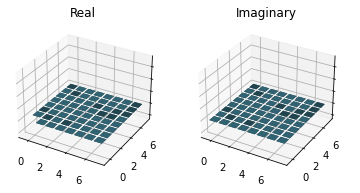

(<Figure size 432x288 with 2 Axes>,
 [<Axes3DSubplot:title={'center':'Real'}>,
  <Axes3DSubplot:title={'center':'Imaginary'}>])

In [1]:
""" Initializing a density matrix of size n, with every qubit in state |0> """

from src.backends.density_matrix.state import DensityMatrix

n = 3
dm_state = DensityMatrix(n)

# We can print the density matrix
print(dm_state.data)

# Or we can view it via matplotlib... Though there seems to be an unfortunate non-visible square that happens to be the one we want
dm_state.draw()

[[0.0625 0.     0.     0.     0.     0.     0.     0.     0.     0.
  0.     0.     0.     0.     0.     0.    ]
 [0.     0.0625 0.     0.     0.     0.     0.     0.     0.     0.
  0.     0.     0.     0.     0.     0.    ]
 [0.     0.     0.0625 0.     0.     0.     0.     0.     0.     0.
  0.     0.     0.     0.     0.     0.    ]
 [0.     0.     0.     0.0625 0.     0.     0.     0.     0.     0.
  0.     0.     0.     0.     0.     0.    ]
 [0.     0.     0.     0.     0.0625 0.     0.     0.     0.     0.
  0.     0.     0.     0.     0.     0.    ]
 [0.     0.     0.     0.     0.     0.0625 0.     0.     0.     0.
  0.     0.     0.     0.     0.     0.    ]
 [0.     0.     0.     0.     0.     0.     0.0625 0.     0.     0.
  0.     0.     0.     0.     0.     0.    ]
 [0.     0.     0.     0.     0.     0.     0.     0.0625 0.     0.
  0.     0.     0.     0.     0.     0.    ]
 [0.     0.     0.     0.     0.     0.     0.     0.     0.0625 0.
  0.     0.     0.     0.   

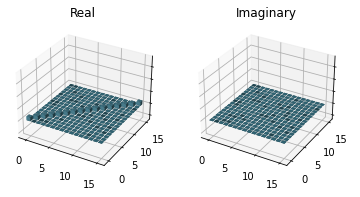

(<Figure size 432x288 with 2 Axes>,
 [<Axes3DSubplot:title={'center':'Real'}>,
  <Axes3DSubplot:title={'center':'Imaginary'}>])

In [2]:
""" Initializing a density matrix from a numpy array """

# We can initialize it from any defined numpy array of adequate dimensions
import numpy as np

n = 4
data = np.eye(2 ** n)  # this generates an identity matrix for an n-qubit state
dm_state = DensityMatrix(data)

print(dm_state.data)

dm_state.draw()

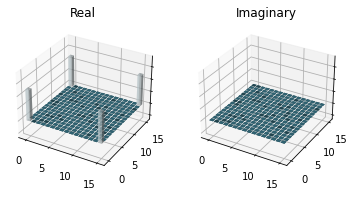

(<Figure size 432x288 with 2 Axes>,
 [<Axes3DSubplot:title={'center':'Real'}>,
  <Axes3DSubplot:title={'center':'Imaginary'}>])

In [3]:
""" Initializing a state with density matrix helper functions """

# Some states can be more difficult to build from scratch. 
# Our code base provides helper functions for density matrix numpy manipulation, which can be used as needed
import src.backends.density_matrix.functions as dmf

# 4-qubit GHZ state: |phi> = 1/sqrt(2) * (|0000> + |1111>)
ghz4_dm = dmf.ket2dm(
            (dmf.tensor(4 * [dmf.state_ketz0()]) + dmf.tensor(4 * [dmf.state_ketz1()])) / np.sqrt(2)
        )

ghz4_state = DensityMatrix(ghz4_dm)
ghz4_state.draw()

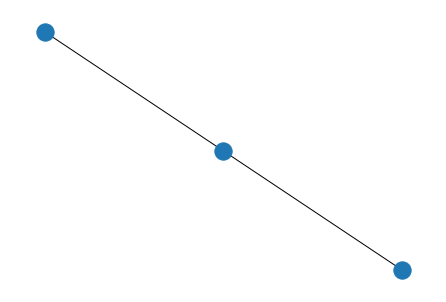

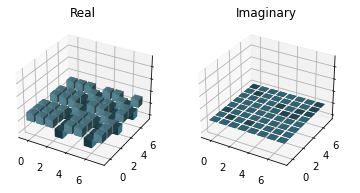

(<Figure size 432x288 with 2 Axes>,
 [<Axes3DSubplot:title={'center':'Real'}>,
  <Axes3DSubplot:title={'center':'Imaginary'}>])

In [4]:
""" 
Defining a target state from a graph by converting the target graph to a density matrix

When the target state is a graph state, it tends to be easiest to express them as graphs. Those can then be converted
a density matrix.
"""

import networkx as nx  # this is a graph-manipulation python library. We use it for our DAG circuits as well

linear_cluster_3_graph = nx.Graph([(1, 2), (2, 3)])  # Edge between node 1-2, node 2-3
nx.draw(linear_cluster_3_graph)

linear_cluster_3_state = DensityMatrix.from_graph(linear_cluster_3_graph)
linear_cluster_3_state.draw()

### Further transformations on the `DensityMatrix` state representation [General API]

When working on the compiler (or possibly when initializing a more complicated target state, the additional functionalities of the `DensityMatrix` class may become useful.

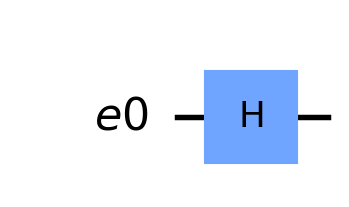

(<Figure size 432x288 with 1 Axes>, <AxesSubplot:>)

In [5]:
""" Apply a unitary transformation """

# Suppose that we want to simulate the following circuit: a single qubit, a single gate
from src.circuit import CircuitDAG
from src.ops import Hadamard

c = CircuitDAG()
c.add(Hadamard(register=0, reg_type='e'))
c.draw_circuit()

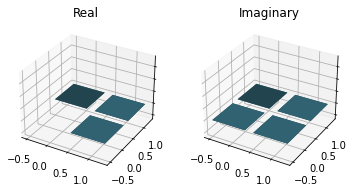

(<Figure size 432x288 with 2 Axes>,
 [<Axes3DSubplot:title={'center':'Real'}>,
  <Axes3DSubplot:title={'center':'Imaginary'}>])

In [6]:
# Before any gates are applied, the density matrix data are the default values when the DensityMatrix is initialized by an integer n
n = 1

dm_state = DensityMatrix(n)
dm_state.draw()

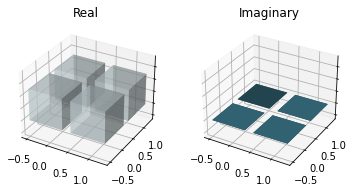

(<Figure size 432x288 with 2 Axes>,
 [<Axes3DSubplot:title={'center':'Real'}>,
  <Axes3DSubplot:title={'center':'Imaginary'}>])

In [7]:
# We can get gates from the density matrix helper functions
#
h_gate = dmf.get_one_qubit_gate(
                n,  # number of total qubits in the state
                0, # index of the density matrix which represents the target qubit
                dmf.hadamard() # the single-qubit state version of the gate we want to apply
            )
dm_state.apply_unitary(h_gate)
dm_state.draw()

This time, the outcome was: 1


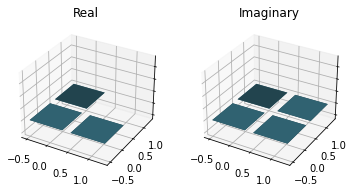

(<Figure size 432x288 with 2 Axes>,
 [<Axes3DSubplot:title={'center':'Real'}>,
  <Axes3DSubplot:title={'center':'Imaginary'}>])

In [8]:
""" Measure a qubit (projects the qubit onto a given basis--we will focus on the computational basis Z)"""

# We measure qubit to convert the (inaccessible to us) quantum information to classical information
projectors = dmf.projectors_zbasis(n, 0)  # this is the basis on which we project
outcome = dm_state.apply_measurement(
            projectors, # the projector
            measurement_determinism='probabilistic'  # most quantum measurements are inherently probabilistic, 
                                                     # but we allow deterministic measurements for algorithmic reasons
        )
print(f'This time, the outcome was: {outcome}')
dm_state.draw()

**NOTE:** We can also apply a quantum channel to the state, but this is mostly used for noise in our application so we will not discuss it here

## TODO: Stabilizer and Graph state

**Relevant python files:** src/backends/graph/state.py, src/backends/graph/functions.py, src/backends/stabilizer/state.py, src/backends/stabilizer/functions*

These states do not have a fully implemented compiler yet, so (due to the expected number of changes these classes may see before they become useful) there is no tutorial for them at this time.

Their current states can be viewed in the source code

## QuantumState representation [General API]

**Relevant python files:** src/state.py

At this time, the QuantumState representation is quite bare-bones. However, a lot of planned functionality will be added to it (including changes from the `deterministic_solver_li_et_al` branch).

I would suggest looking at the code and `TODO` statements. For now, we will only go over initialization.

**NOTE:** All data representations which are valid initializers for `DensityMatrix`, `Stabilizer` or `Graph` are valid initialization data for `QuantumState`

In [9]:
""" Initializing a single representation """
from src.state import QuantumState

n = 2
data = np.eye(2 ** n)

state = QuantumState(
    n, # number of qubits in the state
    data, # initialization data
    representation='density matrix'  # can also be 'graph' or 'stabilizer'
)

print(state.dm.data)

[[0.25 0.   0.   0.  ]
 [0.   0.25 0.   0.  ]
 [0.   0.   0.25 0.  ]
 [0.   0.   0.   0.25]]


[[ 0.125  0.125  0.125 -0.125  0.125  0.125 -0.125  0.125]
 [ 0.125  0.125  0.125 -0.125  0.125  0.125 -0.125  0.125]
 [ 0.125  0.125  0.125 -0.125  0.125  0.125 -0.125  0.125]
 [-0.125 -0.125 -0.125  0.125 -0.125 -0.125  0.125 -0.125]
 [ 0.125  0.125  0.125 -0.125  0.125  0.125 -0.125  0.125]
 [ 0.125  0.125  0.125 -0.125  0.125  0.125 -0.125  0.125]
 [-0.125 -0.125 -0.125  0.125 -0.125 -0.125  0.125 -0.125]
 [ 0.125  0.125  0.125 -0.125  0.125  0.125 -0.125  0.125]]
Graph with 3 nodes and 2 edges


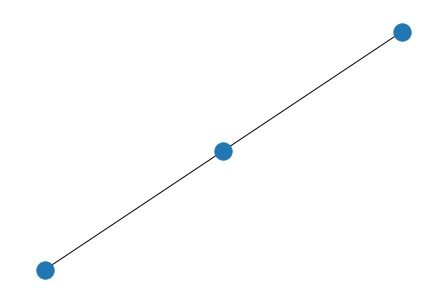

In [10]:
""" Initializing multiple representations (may be useful for more advanced compilers)"""

n = 3

linear_cluster_3_graph = nx.Graph([(1, 2), (2, 3)])  # Edge between node 1-2, node 2-3
nx.draw(linear_cluster_3_graph)

# Set data via initialization
linear3_dm = DensityMatrix.from_graph(linear_cluster_3_graph).data

state = QuantumState(
    n,
    [linear_cluster_3_graph, linear3_dm],
    representation=['graph', 'density matrix']
)
print(state.dm.data)
print(state.graph.data)

## Conversion between state representations

Not all representations can be converted to one another without loss of information.
* The `Graph` representation can represent only a class of quantum states called graph states, and is the least general. 
* The `Stabilizer` representation is more general, and can represent any "pure states" (there are no unknowns associated with classical probabilities).
* The `DensityMatrix` representation is most general of all, and can represent both pure states and mixed states.

However, we still have functions to convert between all these states (albeit imperfectly in some cases--and the limitations are important to understand).

Note that these functions act on the underlying representations of different states (i.e. numpy array, networkx Graph), not on the state objects themselves.

(<Figure size 432x288 with 2 Axes>,
 [<Axes3DSubplot:title={'center':'Real'}>,
  <Axes3DSubplot:title={'center':'Imaginary'}>])

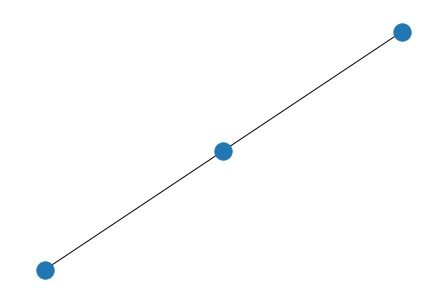

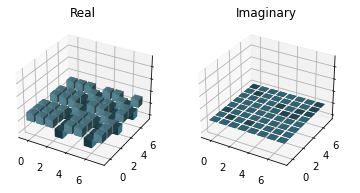

In [13]:
""" Graph to density matrix"""
import src.backends.state_representation_conversion as stc
import src.visualizers.density_matrix as vdm

linear3_g = nx.Graph([(1, 2), (2, 3)])  # Edge between node 1-2, node 2-3
linear3_dm = stc.graph_to_density(linear3_g)

nx.draw(linear3_g)
vdm.density_matrix_bars(linear3_dm)

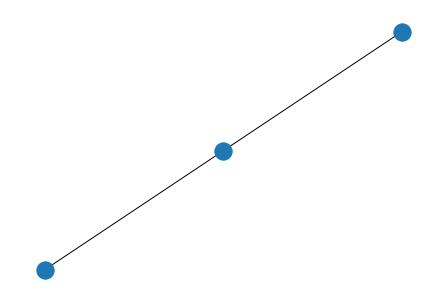

In [28]:
""" Density matrix to graph: exact """

# we know that linear3_dm is a graph state--we can convert it back to a graph
linear3_graph_from_dm = nx.from_numpy_matrix(stc.density_to_graph(linear3_dm, threshold=0.4999))
nx.draw(linear3_graph_from_dm)

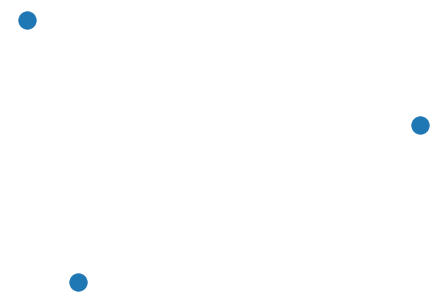

In [29]:
# CAREFUL. density_to_graph is not an exact conversion for reasons explained above
# If we change the threshold (even by a very small amount), the resulting graph may change
linear3_graph_from_dm2 = nx.from_numpy_matrix(stc.density_to_graph(linear3_dm, threshold=0.5))
nx.draw(linear3_graph_from_dm2)

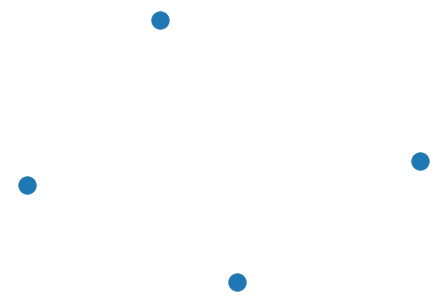

In [39]:
""" Density matrix to graph, inexact """

# Let's consider something that is NOT a graph state now (e.g. the GHZ4 state)
ghz4_dm = dmf.ket2dm(
            (dmf.tensor(4 * [dmf.state_ketz0()]) + dmf.tensor(4 * [dmf.state_ketz1()])) / np.sqrt(2)
        )

# No edge seems to be added here, no matter how low we drive the threshold
ghz4_g_from_dm1 = nx.from_numpy_matrix(stc.density_to_graph(ghz4_dm, threshold=0.00001))
nx.draw(ghz4_g_from_dm1)

['XZI', 'ZXZ', 'IZX']


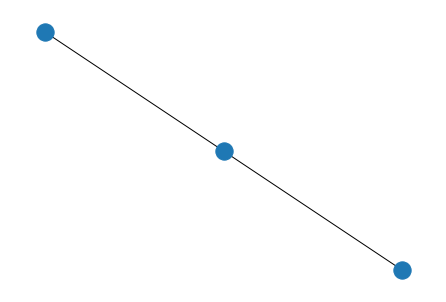

In [42]:
""" Graph to stabilizer and back """
linear3_stabilizer = stc.graph_to_stabilizer(linear3_g)
print(linear3_stabilizer)
nx.draw(stc.stabilizer_to_graph(linear3_stabilizer))

['XZI', 'ZXZ', 'IZX']


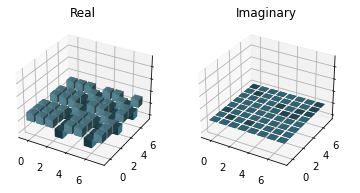

In [43]:
""" Stabilizer to density and back """
linear3_dm_from_stabilizer = stc.stabilizer_to_density(linear3_stabilizer)
vdm.density_matrix_bars(linear3_dm_from_stabilizer)
linear3_stabilizer_from_dm = stc.density_to_stabilizer(linear3_dm_from_stabilizer)
print(linear3_stabilizer_from_dm)